In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [0]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 96
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 100
config.print_freq = 50


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [5]:
len(dataloader)

625

In [0]:
all_classes=set()
for image, cat in dataloader:
    for c in cat:
        all_classes.add(c.item())
config.num_classes=len(all_classes)

In [7]:
image.size()

torch.Size([96, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.inl=nn.Linear(config.noise_size+config.num_classes,128*3*3)
        self.model = nn.Sequential(
            nn.BatchNorm2d(128), #3x3
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0), #7x7
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1,output_padding=1), #14x14
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1,output_padding=1), #28x28
            nn.Tanh()) 
        
    def forward(self, x):
        x=self.inl(x).view(-1,128,3,3)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.inl=nn.Linear(28*28+config.num_classes,32*14*14)
        self.model = nn.Sequential(
            #nn.Conv2d(1, 32, 3, stride=2, padding=1), #14x14
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, 3, stride=2, padding=1), #7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 3, stride=2, padding=0), #3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2))
        self.outl=nn.Linear(128*3*3+config.num_classes, 1)
    def forward(self, x):
        y=x[:,-config.num_classes:]
        x=self.inl(x).view(-1,32,14,14)
        x=self.model(x)
        x=torch.cat([x.view(x.size(0),-1),y],dim=1)
        return self.outl(x)

In [0]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [0]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0002)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0002)

#criterion = nn.BCELoss()
criterion = nn.MSELoss()

### Create necessary variables

In [0]:
noise_mean=0
noise_std=1
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(noise_mean, noise_std))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0


### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [0]:
from random import randint

In [0]:
def gen_noise(l=None):
    noise.data.normal_(noise_mean,noise_std)
    if l is None:
        l=[randint(0,9) for _ in range(noise.size(0))]
    tmp=torch.zeros(noise.size(0),10)
    tmp[range(tmp.size(0)),l]=1
    return torch.cat([noise,tmp],dim=1),tmp

In [0]:
config.num_epochs=50

In [38]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######

        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)

        tmp=torch.zeros(cat.size(0),10)
        tmp[range(tmp.size(0)),cat]=1
        input_data=torch.cat([images.view(images.size(0),-1)*2-1,tmp],dim=1)

        output = discriminator(input_data)
        errD_x = criterion(output.view(-1), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
            
        # fake 
        cat_noise,tmp=gen_noise()
        
        fake = generator(cat_noise)
        label.data.fill_(fake_label)

        cat_fake=torch.cat([fake.view(-1,28*28),tmp],dim=1)

       

        output = discriminator(cat_fake.detach())
        errD_z = criterion(output.view(-1), label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        optim_D.zero_grad()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(cat_fake)
        errG = criterion(output.view(-1), label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        optim_G.zero_grad()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 50 errD_x: 0.01 errD_z: 0.01 errG: 1.40
Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.03 errG: 1.18
Epoch:1 Iter: 150 errD_x: 0.00 errD_z: 0.01 errG: 0.86
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.02 errG: 1.11
Epoch:1 Iter: 250 errD_x: 0.00 errD_z: 0.01 errG: 1.10
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.98
Epoch:1 Iter: 350 errD_x: 0.00 errD_z: 0.00 errG: 1.17
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 1.18
Epoch:1 Iter: 450 errD_x: 0.00 errD_z: 0.00 errG: 1.21
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 1.20
Epoch:1 Iter: 550 errD_x: 0.00 errD_z: 0.01 errG: 1.21
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.01 errG: 0.99
Epoch:2 Iter: 50 errD_x: 0.01 errD_z: 0.00 errG: 1.00
Epoch:2 Iter: 100 errD_x: 0.01 errD_z: 0.00 errG: 1.22
Epoch:2 Iter: 150 errD_x: 0.01 errD_z: 0.00 errG: 0.66
Epoch:2 Iter: 200 errD_x: 0.01 errD_z: 0.01 errG: 1.10
Epoch:2 Iter: 250 errD_x: 0.00 errD_z: 0.03 errG: 0.74
Epoch:2 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 0.93
Epoch:2 Iter

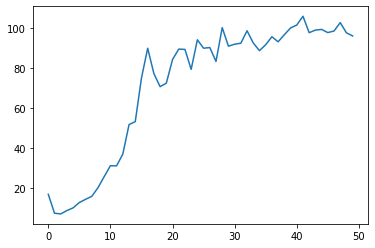

In [86]:
plt.plot(np.arange(50),ERRD_x) # Насколько хорошо дискриминатор угадывает реальные данные

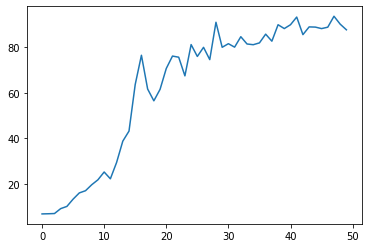

In [87]:
plt.plot(np.arange(50),ERRD_z) # Насколько хорошо дискриминатор угадывает fake

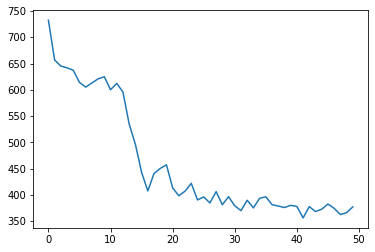

In [88]:
plt.plot(np.arange(50),ERRG) # Насколько часто генератор принимает fake за реальность

***Видно, что ошибка генератора уменьшается, но ошибка дискриминатора увеличивается. Это связанно с тем, что чем лучше генератор иммитирует реальные данные, тем сложнее дискриминатору давать правильный ответ. В конечном итоге всё должно сойтись к тому, что дискриминатор будет вынужден классифицировать данные с вероятностью 0.5***

In [0]:
generator=generator.eval()

***Далее приведены результаты работы генератора (LSGan, условная генерация, свёртки)<br>
Пару слов об обучении:<br>
1) Обязательность использовать свёртки и батчнормализацию<br>
2) Не использовать кросс энтропию<br>
3) Следует всегда следить за балансом обучения дискриминатора и генератора (с хорошим лоссом обучение в любом случае не должно окончательно затухнуть, но балансируя обучение мы можем ускорить сходимость, а ганы считаются довольно медленно, поэтому ускорение лишним не будет)<br>
4) При условной генерации желательно пропихивать вектор класса во все слои (но для этого нужно считать дополнительно несколько линейных слоёв, чтобы размерность совпадала, а я не хотел, чтобы вычисления были ещё более медленными)<br>
5) Мне кажется, что условная генерация значительно помогает дискриминатору, но усложняет обучение для генератора, поэтому стоит обновлять дискриминатор чаще (например видно, что первые несколько эпох дискриминатор работает очень хорошо, и его можно обновлять реже)***

tensor([2, 5, 1, 7, 9, 5, 0, 8, 9, 8, 3, 4, 8, 6, 6, 7])


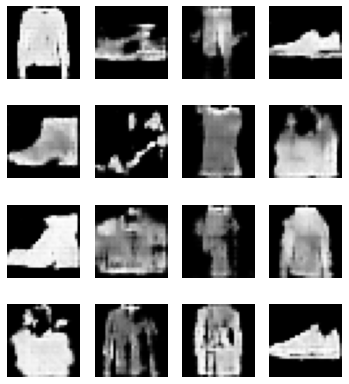

In [48]:
cat_noise,tmp=gen_noise()
l=tmp.argmax(dim=1)
print(l[:16])

fake = generator(cat_noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

tensor([1, 6, 3, 3, 9, 7, 9, 8, 4, 6, 0, 5, 5, 4, 2, 4])


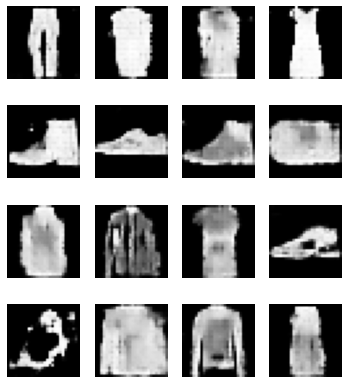

In [39]:
#noise.data.normal_(noise_mean, noise_std) # LSGan std=1
cat_noise,tmp=gen_noise()
l=tmp.argmax(dim=1)
print(l[:16])

fake = generator(cat_noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


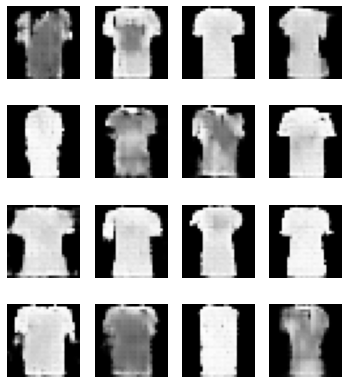

In [50]:
cat_noise,tmp=gen_noise([0]*noise.size(0))
l=tmp.argmax(dim=1)
print(l[:16])

fake = generator(cat_noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


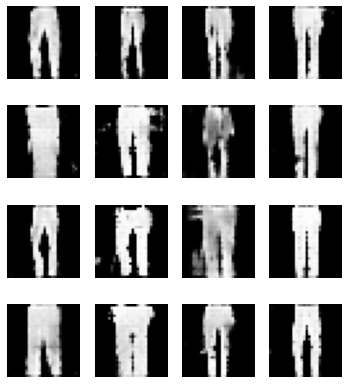

In [51]:
cat_noise,tmp=gen_noise([1]*noise.size(0))
l=tmp.argmax(dim=1)
print(l[:16])

fake = generator(cat_noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])


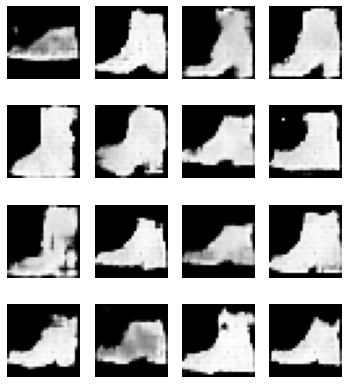

In [52]:
cat_noise,tmp=gen_noise([9]*noise.size(0))
l=tmp.argmax(dim=1)
print(l[:16])

fake = generator(cat_noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

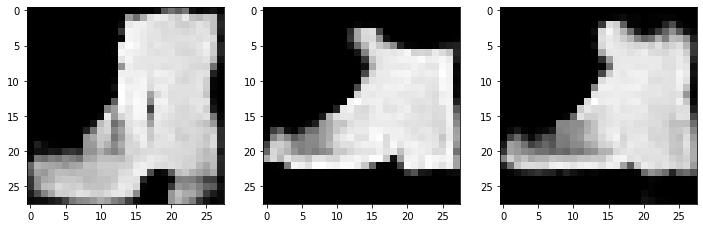

In [83]:
cat_noise,_=gen_noise([9]*noise.size(0))

fake = generator(cat_noise[:2])

inter_noise=cat_noise[:2].mean(dim=0,keepdim=True)
inter_noise.shape
inter_fake = generator(inter_noise)


plt.figure(figsize=(12, 7))

plt.subplot(1,3,1)
plt.imshow(fake[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

plt.subplot(1,3,2)
plt.imshow(fake[1].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

plt.subplot(1,3,3)
plt.imshow(inter_fake[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

***Из-за условной генерации интерполяцию можно проводить только между элементами одного класса. Справа находится интерполяция двух картинок***

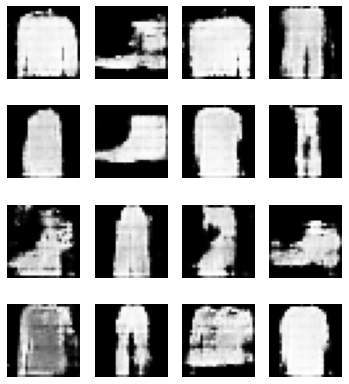

In [0]:
noise.data.normal_(noise_mean, noise_std) # LSGan + свёртки
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

***Сверху результат с LSGan-ом и свёртками. Обучается медленно. Изображения получаются весьма хорошими, иногда проявляются артефакты***

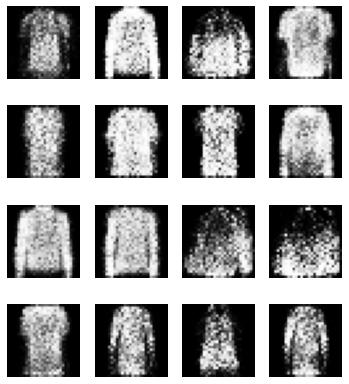

In [0]:
noise.data.normal_(noise_mean, noise_std) # LSGan
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

***Сверху результат с LSGan-ом. Всё так-же быстро. Изображения получаются более цельными, начинаются появляються какие-то детали***

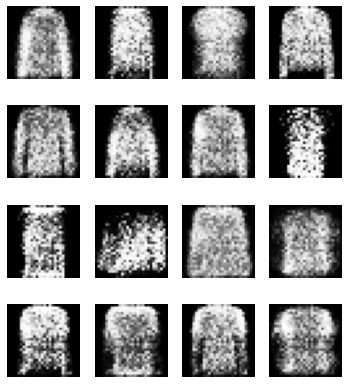

In [0]:
noise.data.normal_(noise_mean, noise_std) #Кросс энтропия
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

***Сверху результат с кросс энтропией. Тренируется довольно быстро. Изображения получаются не цельными, мало деталей***

In [0]:
for images,cat in dataloader:
    break

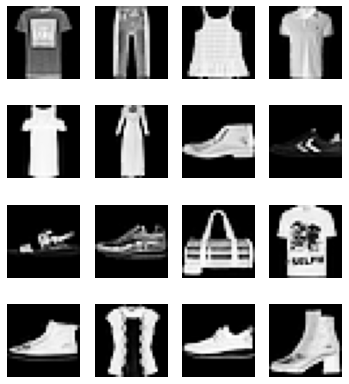

In [0]:
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].reshape(28, 28),cmap=plt.cm.Greys_r)
    plt.axis('off')